# Practical Aspects of Image Classification

- **Topics will be covered in this chapter:**
    - Generating class activation maps (CAMs).
    - Understanding the impact of batch normalization and data augmentation
    - Practical aspects to take care of during model implementation

---
# Generating CAMs

###### This process helps to visualize and understand which parts of an image are particularly important for a neural network when identifying a specific class. The method uses gradients to highlight the relevant features in the intermediate activation maps.


- **Scenario**: Stakeholder wants to understand the reasoning behind a model's predictions.

- **Solution**: Class Activation Maps (CAMs) provide insight into model predictions.

- CAMs help interpret model decisions and provide transparency in prediction rationale.

Summary of CAM Generation:

- **Feature Maps:**
  - Intermediate activations post-convolution.
  - Typically in the shape of n-channels x height x width.

- **Identifying Hotspots:**
  - Mean of all activations reveals hotspots for all classes.

- **Class-specific Hotspots:**
  - To pinpoint locations crucial for a specific class (e.g., cat).
  - Identify feature maps among n-channels responsible for that class.

- **Gradient Computation:**
  - Compute gradients for the convolution layer corresponding to the cat class.
  - High gradients only in channels responsible for predicting cats.

- **Weightage Assignment:**
  - Utilize gradient information to assign weightage to each of n-channels.
  - Obtain an activation map exclusively highlighting areas relevant to the cat class.

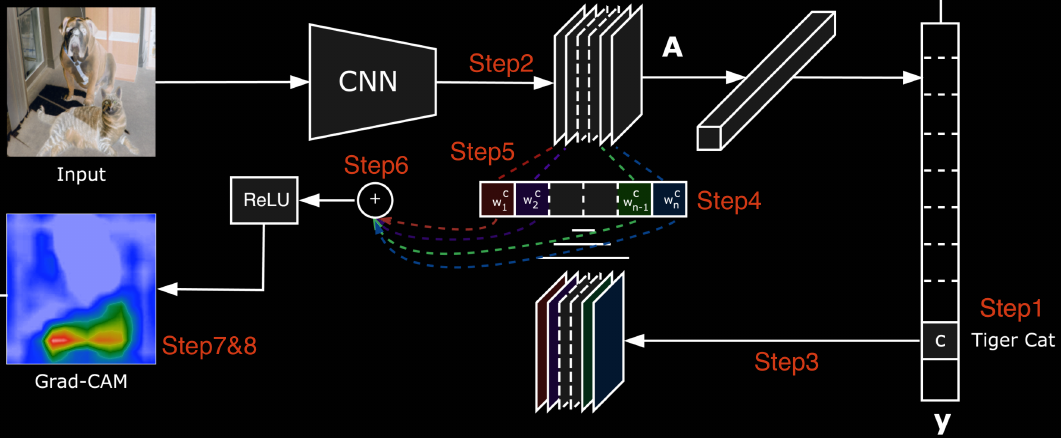

1. **Class and Layer Selection:**
   - Choose the target class and the convolutional layer for CAM computation.

2. **Activation Calculation:**
   - Calculate activations from the chosen convolutional layer.
   - Example: Feature shape is 512 x 7 x 7.

3. **Gradient Retrieval:**
   - Fetch gradient values from this layer concerning the class of interest.
   - Output shape: 256 x 512 x 3 x 3.

4. **Gradient Mean Calculation:**
   - Compute the mean of gradients within each output channel.
   - Output shape: 512.

5. **Weighted Activation Map:**
   - Multiply the 512 gradient means by the 512 activation channels.
   - Output shape: 512 x 7 x 7.

6. **Mean Across Channels:**
   - Calculate the mean across the 512 channels for a 7 x 7 output.

7. **Resize Activation Map:**
   - Upscale the weighted activation map to match the input image size.

8. **Overlay onto Input Image:**
   - Overlay the resized activation map onto the original input image.

The key to the entire process lies in step 5. We consider two aspects of the step:
- If a certain pixel is important, then the CNN will have a large activation at those pixels.
- If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large

---
## CAMs implemented in code

In [1]:
# 1. Download the dataset and import the relevant packages
# Standard library imports
from pathlib import Path
from random import randint

# Third party imports
import cv2
from glob import glob
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [5]:
# Constants
IMAGE_SIZE = 128
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

# Specify the indices corresponding to the output classes
id2int = {'Parasitized': 0, 'Uninfected': 1}


# Define transformations for training images
train_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ColorJitter(brightness=(0.95,1.05),
                contrast=(0.95,1.05),
                saturation=(0.95,1.05),
                hue=0.05),
    v2.RandomAffine(5, translate=(0.01,0.1)),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

# Specify the transformations for validation images
validation_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.Compose([v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=MEAN, std=STD),
])

In [12]:
# 4. Define the dataset class – MalariaImages
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = list(map(str, files))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = os.path.split(os.path.dirname(fpath))[-1]
        img = cv2.imread(fpath, 1)
        if self.transform:
            img = self.transform(img)
        return img, clss
        
    def choose(self):
        return self[torch.randint(len(self), size=(1,)).item()]

    def collate_fn(self, batch):
        imgs, classes = zip(*batch)
        classes = torch.tensor([id2int[clss] for clss in classes])
        imgs = torch.stack(imgs).to(device)
        classes = classes.to(device)
        return imgs, classes


In [13]:
# 5. Fetch the training and validation datasets and dataloaders
# Constants
SEED = 10
BATCH_SIZE = 32

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get all image files
all_files = glob('/home/fox/Desktop/Modern Computer Vision/Chapter06/cell_images/*/*.png')

# Set seed and shuffle files
np.random.seed(SEED)
np.random.shuffle(all_files)

# Split files into training and validation sets
train_files, validation_files = train_test_split(all_files, random_state=1)

# Create datasets
train_dataset = MalariaImages(train_files, transform=train_transforms)
validation_dataset = MalariaImages(validation_files, transform=validation_transforms)

# Create data loaders
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
validation_dataloader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, collate_fn=validation_dataset.collate_fn)

In [14]:
# 6. Define the model – MalariaClassifier
def create_convolutional_block(input_channels, output_channels):
    """
    Creates a convolutional block with dropout, convolution, ReLU activation,
    batch normalization and max pooling.
    """
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_channels),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    """
    A classifier for detecting Malaria in images.
    """
    def __init__(self):
        super().__init__()
        layers = []
        channels = [3, 64, 64, 128, 256, 512, 64]
        for i in range(len(channels)-1):
            layers.append(create_convolutional_block(channels[i], channels[i+1]))
        layers.extend([
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int)),
            nn.LogSoftmax(dim=1)
        ])
        self.model = nn.Sequential(*layers)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, predictions, targets):
        """
        Computes the loss and accuracy for the given predictions and targets.
        """
        loss = self.loss_function(predictions, targets)
        accuracy = (torch.max(predictions, 1)[1] == targets).float().mean()
        return loss, accuracy

# 7. Define the functions to train and validate on a batch of data
def train_model_batch(model, batch_data, optimizer, criterion):
    """
    Trains the model for one batch of data.
    
    Parameters:
    model: The model to be trained.
    batch_data: The batch of data to be used for training. It should be a tuple of (images, labels).
    optimizer: The optimizer to be used for training.
    loss_function: The loss function to be used for training.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels = batch_data
    predictions = model(images)
    optimizer.zero_grad()
    loss, accuracy = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    return loss.item() , accuracy.item()

@torch.no_grad()

def validate_model_batch(model, batch_data, criterion):
    """
    Validates the model for one batch of data.
    
    Parameters:
    model: The model to be validated.
    batch_data: The batch of data to be used for validation. It should be a tuple of (images, labels).
    loss_function: The loss function to be used for validation.
    
    Returns:
    The loss and accuracy for the batch as a tuple.
    """
    images, labels = batch_data
    predictions = model(images)
    loss, accuracy = criterion(predictions, labels)
    return loss.item(), accuracy.item()


In [15]:
# 8. Train the model over increasing epochs
def train_and_validate(model, num_epochs, 
                        train_dataloader, 
                        validation_dataloader, 
                        optimizer, criterion, logger):
    """
    Trains and validates the model.

    Parameters:
    model: The model to be trained and validated.
    num_epochs: The number of epochs to train for.
    train_dataloader: The DataLoader for the training data.
    validation_dataloader: The DataLoader for the validation data.
    optimizer: The optimizer to be used for training.
    criterion: The loss function to be used for training and validation.
    logger: The logger to record the loss and accuracy.

    Returns:
    None
    """
    # For each epoch...
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # For each batch of training data...
        for batch_index, batch_data in enumerate(train_dataloader):
            # Train the model on the batch and record the loss and accuracy
            loss, accuracy = train_model_batch(model, batch_data, optimizer, criterion)
            logger.record(epoch + (batch_index + 1) / len(train_dataloader), trn_loss=loss, trn_acc=accuracy, end='\r')

        # Set the model to evaluation mode
        model.eval()

        # For each batch of validation data...
        with torch.no_grad():
            for batch_index, batch_data in enumerate(validation_dataloader):
                # Validate the model on the batch and record the loss and accuracy
                loss, accuracy = validate_model_batch(model, batch_data, criterion)
                logger.record(epoch + (batch_index + 1) / len(validation_dataloader), val_loss=loss, val_acc=accuracy, end='\r')

        # Report the average loss and accuracy for this epoch
        logger.report_avgs(epoch + 1)

In [16]:
# Instantiate the MalariaClassifier model and move it to the GPU if available
model = MalariaClassifier().to(device)

# Set the model's compute_metrics method as the criterion for calculating loss
criterion = model.compute_metrics

# Initialize the Adam optimizer with a learning rate of 0.001 and apply it to the model's parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Set the number of epochs for which the model will be trained
num_epochs = 2

# Initialize a logger to record the training process. The logger will generate a report after each epoch
logger = ts.Report(num_epochs)

# Start the training and validation process. The function will train the model on the training data and validate it on the validation data.
# The optimizer and criterion defined above will be used, and the logger will record the process
train_and_validate(model, num_epochs,
                    train_dataloader, 
                    validation_dataloader,
                    optimizer, criterion, logger)

EPOCH: 1.000  val_loss: 0.232  val_acc: 0.932  trn_loss: 0.231  trn_acc: 0.916  (417.65s - 417.65s remaining)
EPOCH: 2.000  val_loss: 0.161  val_acc: 0.951  trn_loss: 0.170  trn_acc: 0.945  (830.39s - 0.00s remaining)


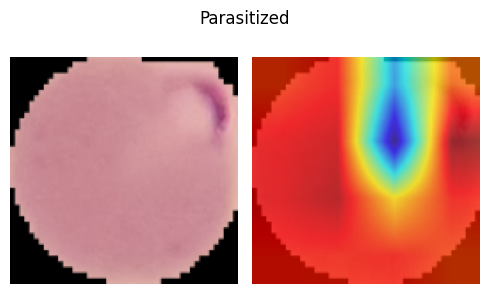

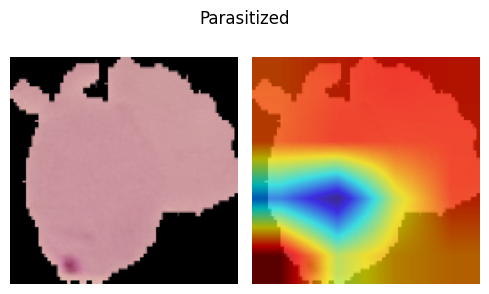

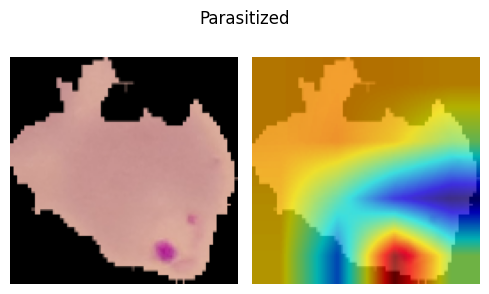

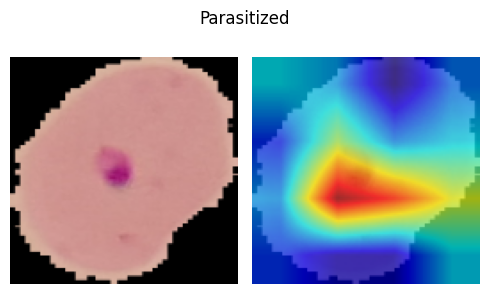

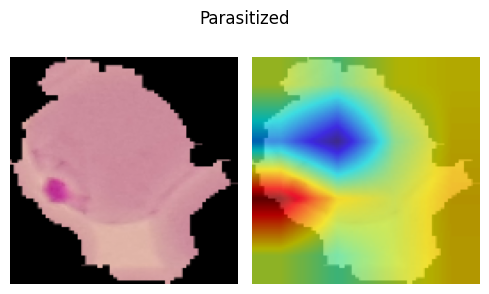

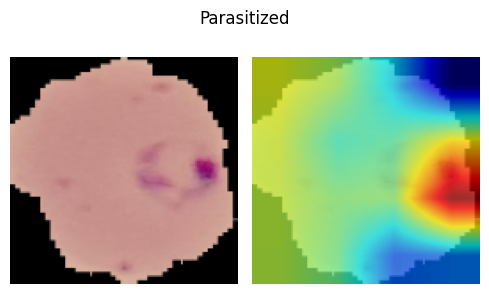

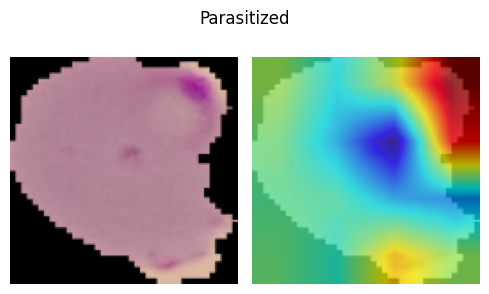

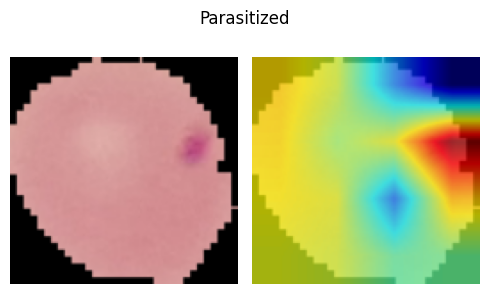

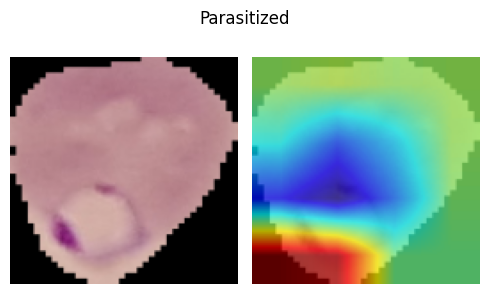

In [17]:
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.file_paths = files
        self.files = [ts.read(f, 1) for f in files]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        img = self.files[ix]
        clss = ts.fname(ts.parent(self.file_paths[ix]))
        return img, clss


    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs



# 9. Fetch the convolution layer in the fifth convBlock in the model

im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

val_ds = MalariaImages(validation_files, transform=validation_transforms)

# 10. Define the im2gradCAM function that takes an input image and fetches the heatmap corresponding to activations of the image
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    activations = im2fmap(x)
    pred = logits.max(-1)[-1]
    logits[0,pred].backward(retain_graph=True)
    pooled_grads = model.model[-8][1].weight.grad.data.mean((1,2,3))
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    model.zero_grad()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

# 11. Define the upsampleHeatmap function to up-sample the heatmap to a shape that corresponds to the shape of the image

SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = ((map-m) / (M-m)) * 255
    map = np.squeeze(map.numpy())  # convert to numpy and remove singleton dimensions
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-np.uint8(map), cv2.COLORMAP_JET)
    map = np.uint8(map*0.7 + img*0.3)
    return map
# 12. Run the preceding functions on a set of images
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = ts.resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    ts.subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

---
# Understanding the impact of data augmentation and batch normalization

- To understand the impact of data augmentation and batch normalization, we will go through a dataset of recognizing traffic signs. We will evaluate three scenarios:
    - No batch normalization/data augmentation
    - Only batch normalization, but no data augmentation
    - Both batch normalization and data augmentation

# Coding up road sign detection

- Let's code up for road sign detection without data augmentation and batch normalization